# Kelvin Wake Image Analysis

Below are some brief expressions that generate images useful for the analysis of Kelvin wake patterns.

In [1]:
from challenging_kelvin import calculate_wake, phi_in, phi_in2
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage
import numpy as np
import pickle
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

The following cell sets up some of the basic information needed for these computations. The following local variables are initialized:

- delta - The base resolution in k-space 
- lambd - The lambda value (analagous to the viscosity of the fluid)
- kmaxs - An array of cutoff kmax values for the Fourier integral calculations
- delts - The resolution for each value of kmax. Generally, higher resolution is needed at lower values of kmax
- bounds - Cutoff standard deviations for image displaying (see below)

All of the local variables are fairly self explanatory, except for bounds. The bounds variable exists because normally, the wake pattern oscillates rapidly in magnitude near the source. The plot color gradient is stretched over a large range of values, which makes it hard to determine behavior far from the source in the resulting images. Because of this, all values that are above or below certain cutoff points are ignored when plotting the wake pattern. Each entry in bounds is equal to the number of standard deviations from zero desired from the cutoff value. The standard deviation approach was chosen because the large scale wake behavior is small to medium oscillations around zero. Ignoring oscillations greater than 2 standard deviations in the case of kmax = 16, for example, makes the large scale behavior of the wake more clear.

In [2]:
delta = 0.03125
lambd = 0.002
kmaxs = [1, 1 + 2 * delta, 1 + 4 * delta, 1 + 6 * delta, 1.25, 1.5, 1.75, 2, 4, 8, 16, 32, 64]
kmaxs = [1, 1 + 2 * delta, 1 + 4 * delta, 1 + 6 * delta, 1.5, 1.75, 2, 3, 4, 8, 16, 32, 64]
delts = np.ones(len(kmaxs)) * delta
bounds = [100, 100, 100, 100, 100, 100, 100, 10, 6, 5, 3, 1.5, 1]


def generate_wake_patterns(kmax, dval):
    phis = []
    xs = []
    for km, dv in zip(kmax, dval):
        x, p = calculate_wake(lambd, km, dv, 1)
        xs.append(x)
        phis.append(np.real(p))
        print('kmax=%f done' % km)
    return xs, phis

In [3]:
pickleFile = 'wake_patterns.pickle'
try:
    with open(pickleFile, 'r') as f:
        phis, xvals, kmaxs, delts, bounds = pickle.load(f)
    print('Loaded from Pickle')
except:
    print('Generating wake patterns')
    xvals, phis = generate_wake_patterns(kmaxs, delts)
    #with open(pickleFile, 'w') as f:
    #    pickle.dump([phis, xvals, kmaxs, delts, bounds], f)
    print('Saved as pickle')
        
#The plot range for all plots, in case the resolution is different
rpl = xvals[-1][-1]

Generating wake patterns
kmax=1.000000 done
kmax=1.062500 done
kmax=1.125000 done
kmax=1.187500 done
kmax=1.500000 done
kmax=1.750000 done
kmax=2.000000 done
kmax=3.000000 done
kmax=4.000000 done
kmax=8.000000 done
kmax=16.000000 done
kmax=32.000000 done
kmax=64.000000 done
Saved as pickle


In [4]:
def format_single_plot(fig, img, title, xlim=[-rpl, 0], ylim=[-rpl, rpl]):
    '''
    Format a single plot, setting title, axis labels/boundaries, colorbar, etc.
    '''
    ax = fig.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.suptitle(title)
    fig.colorbar(img)

def draw_wake_plot(ax, x, phi, kmax, bound, scale=False):
    '''
    Plots the wake pattern and sets the axis boundaries to ignore the mostly
    flat areas ahead of and far outside the wake.
    
    ax - The axes to draw on
    x - The range of x values
    phi - The wake pattern values
    kmax - The k-space cutoff value
    bound - The cutoff standard deviation for plotting
    '''
    r = x[-1]
    stdev = np.std(phi)
    avg = np.average(phi)
    ubound = avg + bound * stdev
    lbound = avg - bound * stdev
    toshow = phi * (phi < ubound) * (phi > lbound)
    toshow[phi > ubound] = ubound
    toshow[phi < lbound] = lbound
    if scale:
        toshow /= np.max(np.abs(toshow[:]))
        img = ax.imshow(toshow, extent=[-r, r, -r, r], interpolation='gaussian', vmin=-1, vmax=1)
    else:
        img = ax.imshow(toshow, extent=[-r, r, -r, r], interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, color='blue'):
    '''
    Draws the kelvin wake angle of 2 theta = 39 degrees on top of the figure
    
    ax - The axes to draw on
    x - The range of x values
    '''
    y = np.sqrt(x**2.0/8.)
    ax.plot(x, y, color=color, linestyle=':')
    #ax.plot(x, -y, color=color, linestyle=':')
    
def draw_inner_angle(ax, x, T, color='red'):
    '''
    Draws the inner wake angle given by arctan(sqrt(kmax - 1) / (2 kmax - 1)
    
    ax - The axes to draw on
    x - The range of x values
    kmax - The k-space cutoff value
    '''
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    #ax.plot(x, y, color=color, linestyle=':')
    ax.plot(x, -y, color=color, linestyle=':')

def draw_parametric_wake(ax, phase, nmax, t, color='red'):
    '''
    Draw the parametric form of the Kelvin wake over the figure
    
    ax - The axes to draw on
    phase - The overall phase term for the wake pattern
    nmax - The number of wakes to draw
    t - The values of t to plot parametrically
    '''
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        #ax.plot(xt, yt, color=color, linestyle=':', linewidth=1)
        ax.plot(xt, -yt, color=color, linestyle=':', linewidth=1)

def calc_T_value(kmax):
    '''
    Calculate the cutoff T value given a cutoff kmax value
    Note that the kmax cutoff value creates a square in k-space
    with side length 2*kmax
    '''
    km2 = kmax * kmax
    if km2 < 2:
        return km2
    return (1. + np.sqrt(1 + 4 * km2)) / 2.

l=0.002000_kmax=1.000000_step=0.031250


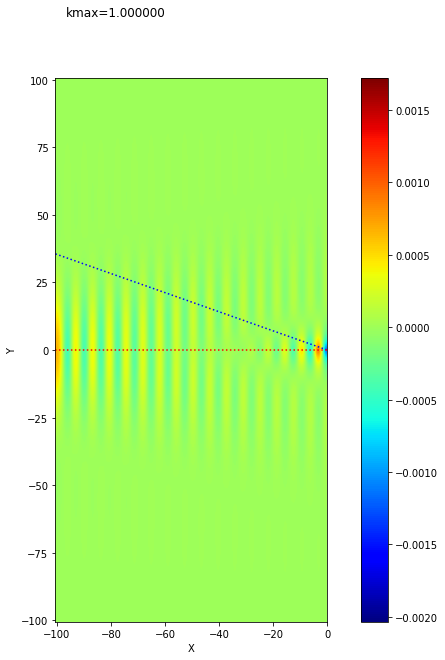

l=0.002000_kmax=1.062500_step=0.031250


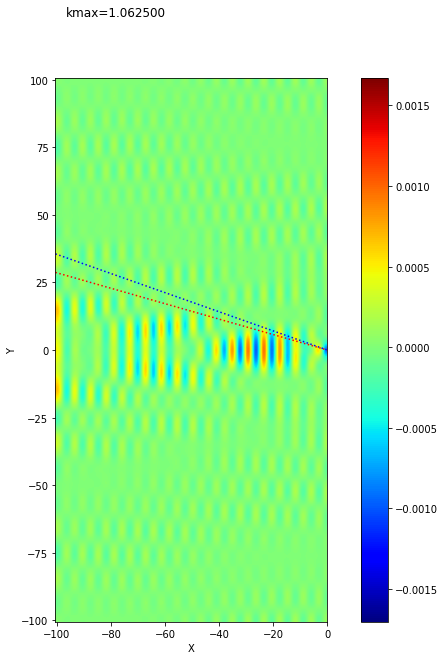

l=0.002000_kmax=1.125000_step=0.031250


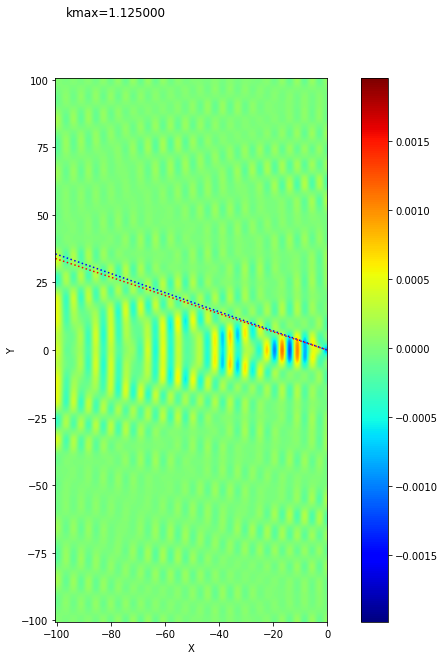

l=0.002000_kmax=1.187500_step=0.031250


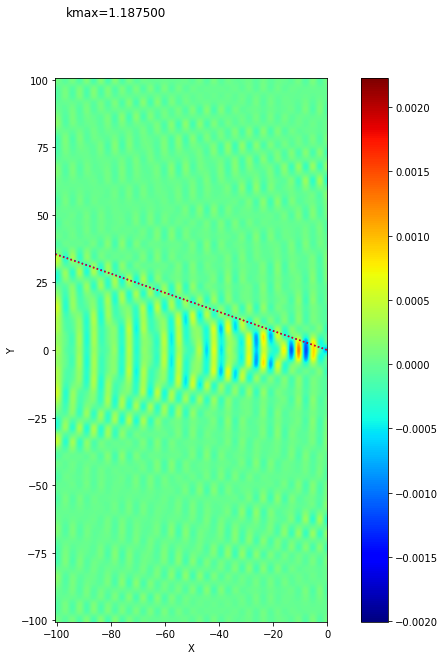

l=0.002000_kmax=1.500000_step=0.031250


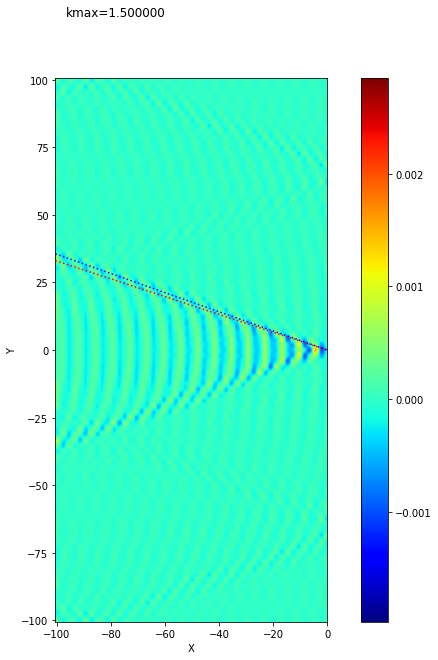

l=0.002000_kmax=1.750000_step=0.031250


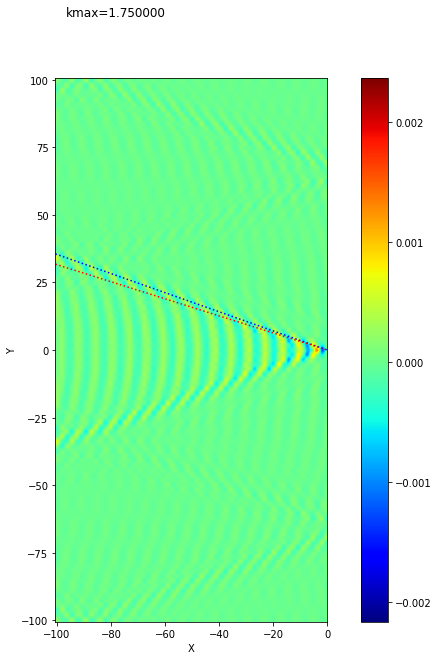

l=0.002000_kmax=2.000000_step=0.031250


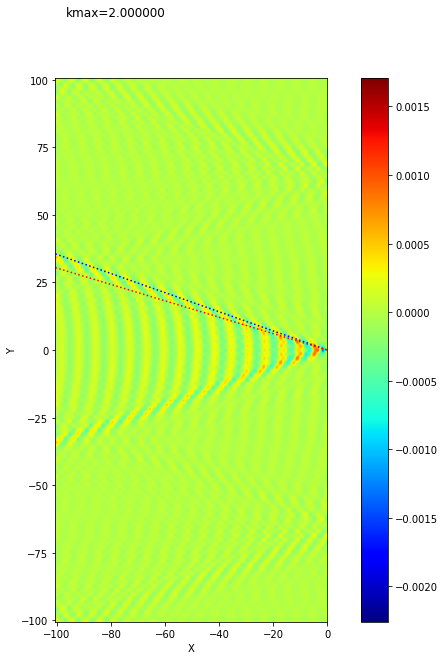

l=0.002000_kmax=3.000000_step=0.031250


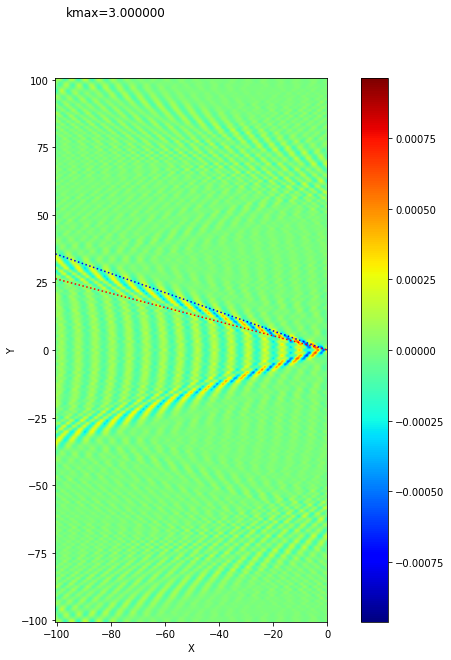

l=0.002000_kmax=4.000000_step=0.031250


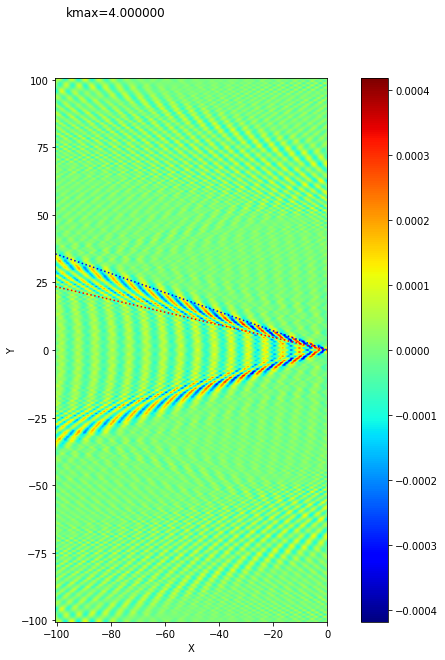

l=0.002000_kmax=8.000000_step=0.031250


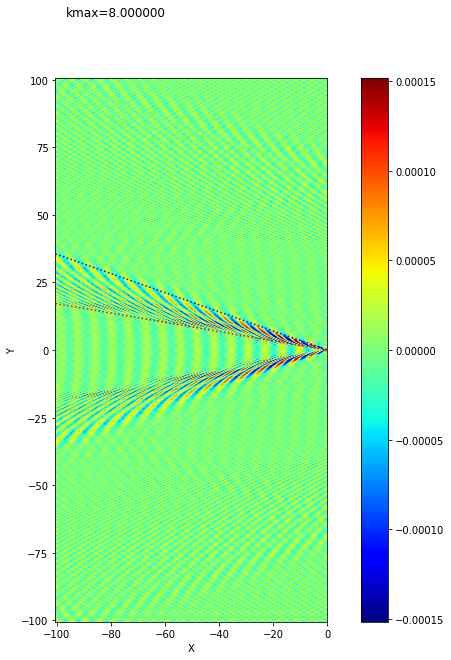

l=0.002000_kmax=16.000000_step=0.031250


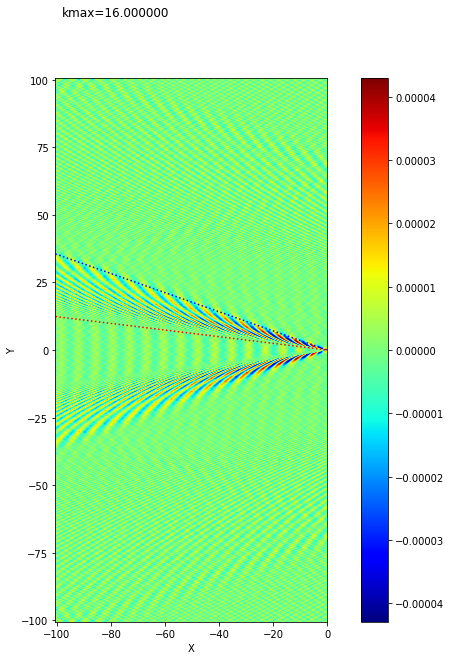

l=0.002000_kmax=32.000000_step=0.031250


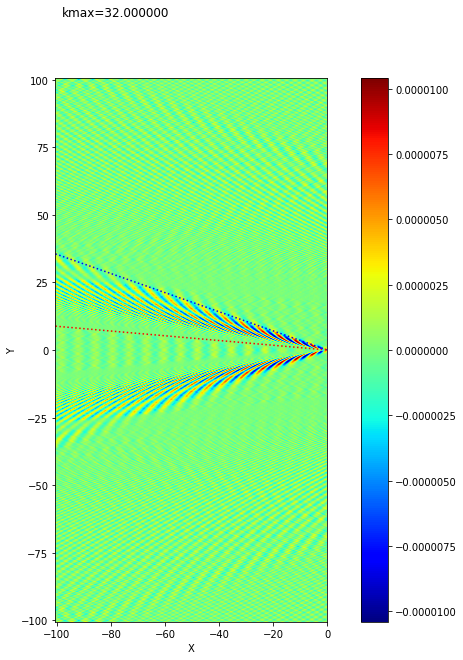

l=0.002000_kmax=64.000000_step=0.031250


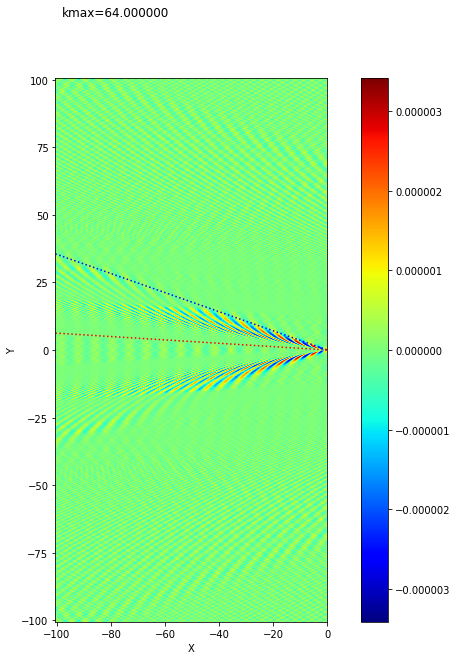

In [5]:
#Create plots for all of our wake patterns
for ind in range(0, len(phis)):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.gca()
    img = draw_wake_plot(ax, xvals[ind], phis[ind], kmaxs[ind], bounds[ind])
    format_single_plot(fig, img, title='kmax=%f' % kmaxs[ind])
    draw_kelvin_angle(ax, xvals[ind])
    draw_inner_angle(ax, xvals[ind], calc_T_value(kmaxs[ind]))
    filename='l=%f_kmax=%f_step=%f' % (lambd, kmaxs[ind], delts[ind])
    print(filename)
    #fig.savefig('/home/jcolen/Documents/kelvinmach/challenging_kelvin/pics/%s.png' % filename)
    #fig.savefig('C:\Users\Jonathan\Documents\School\Kolomeisky\challenging_kelvin\pics\%s.png' % filename)
    plt.show()

parametric_l=0.002000_kmax=1.000000_step=0.031250


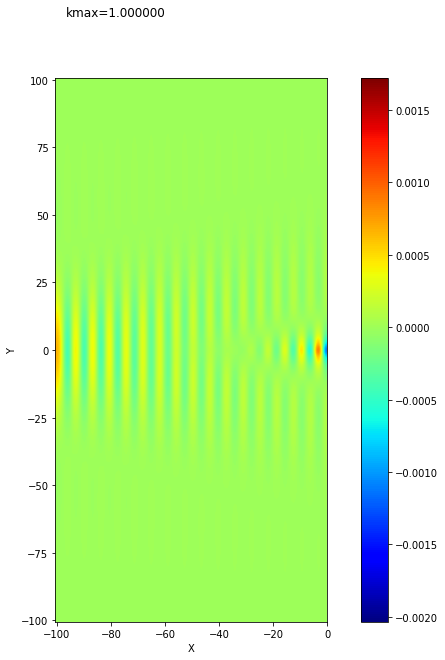

parametric_l=0.002000_kmax=1.062500_step=0.031250


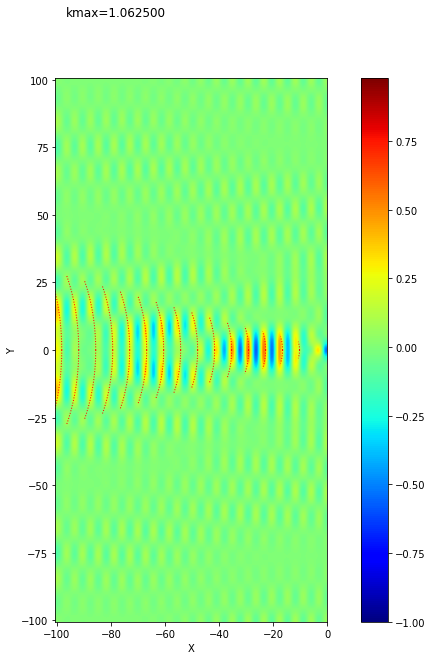

parametric_l=0.002000_kmax=1.125000_step=0.031250


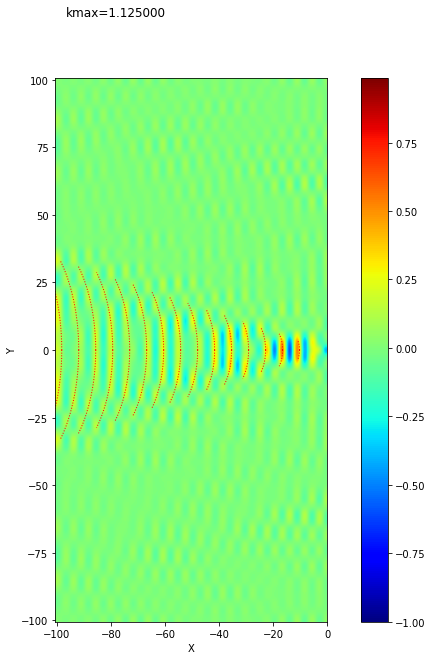

parametric_l=0.002000_kmax=1.187500_step=0.031250


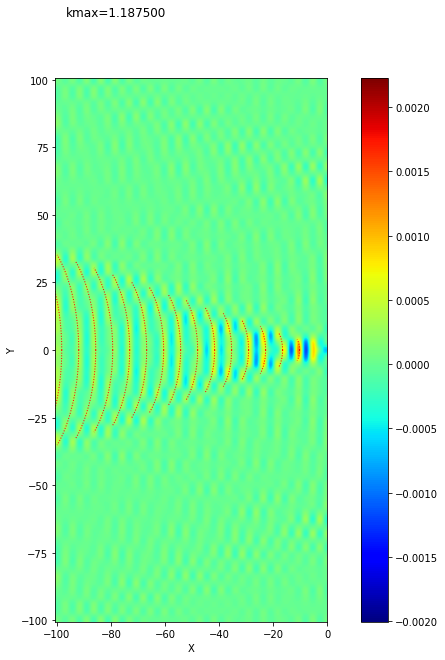

parametric_l=0.002000_kmax=1.250000_step=0.031250


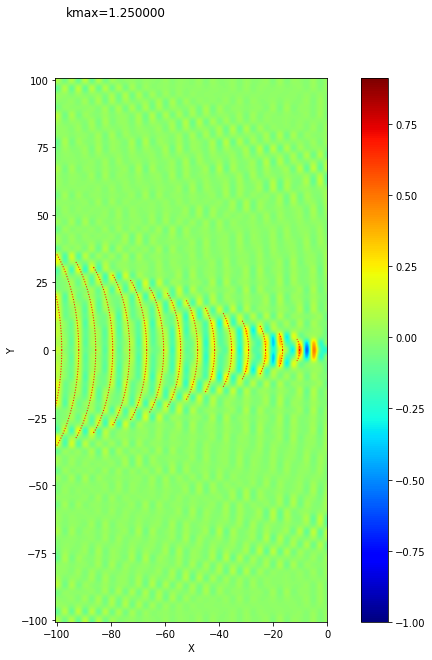

parametric_l=0.002000_kmax=1.500000_step=0.031250


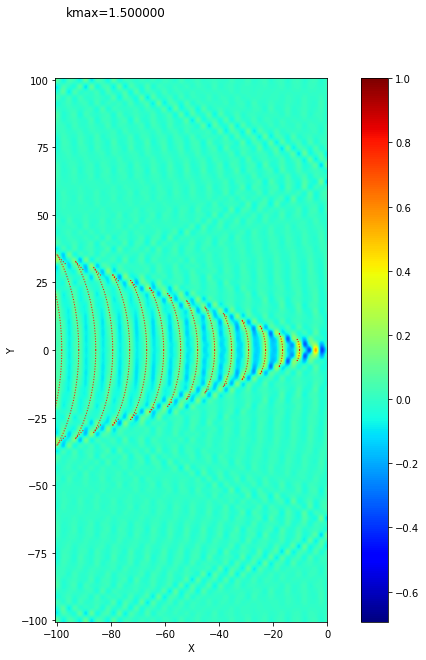

parametric_l=0.002000_kmax=1.750000_step=0.031250


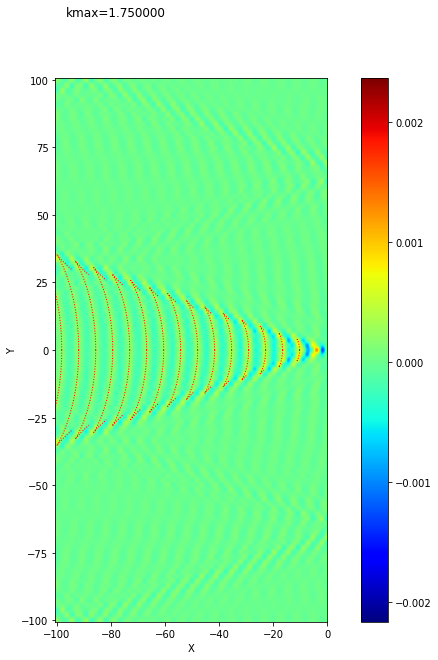

parametric_l=0.002000_kmax=2.000000_step=0.031250


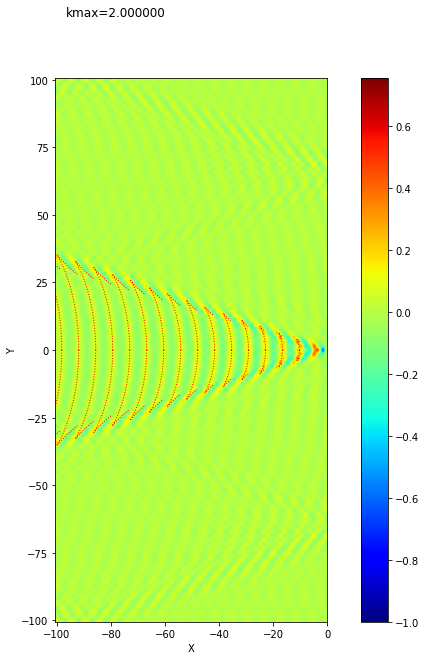

parametric_l=0.002000_kmax=4.000000_step=0.031250


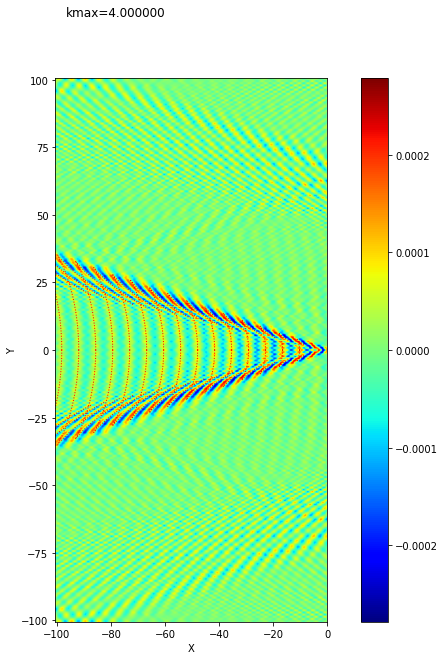

parametric_l=0.002000_kmax=8.000000_step=0.031250


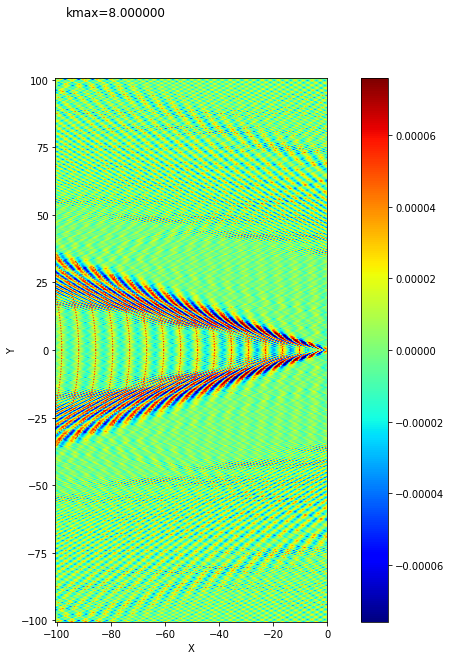

parametric_l=0.002000_kmax=16.000000_step=0.031250


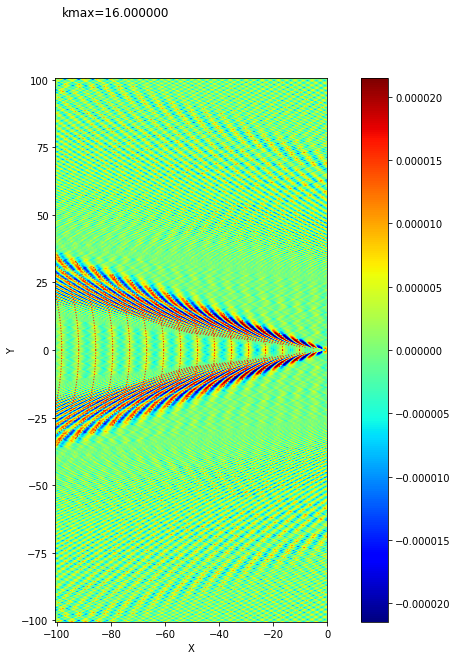

parametric_l=0.002000_kmax=32.000000_step=0.031250


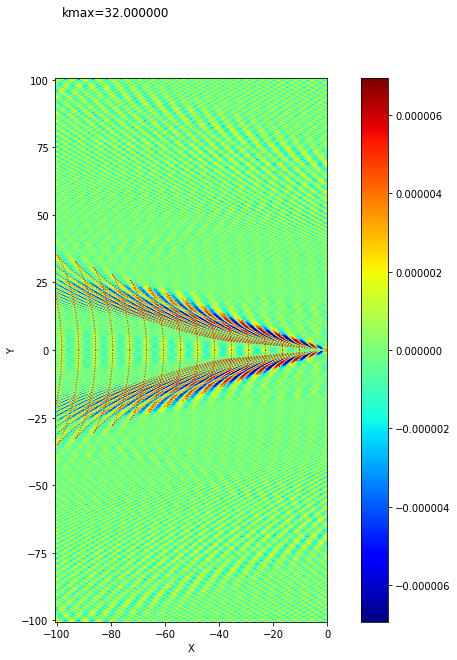

parametric_l=0.002000_kmax=64.000000_step=0.031250


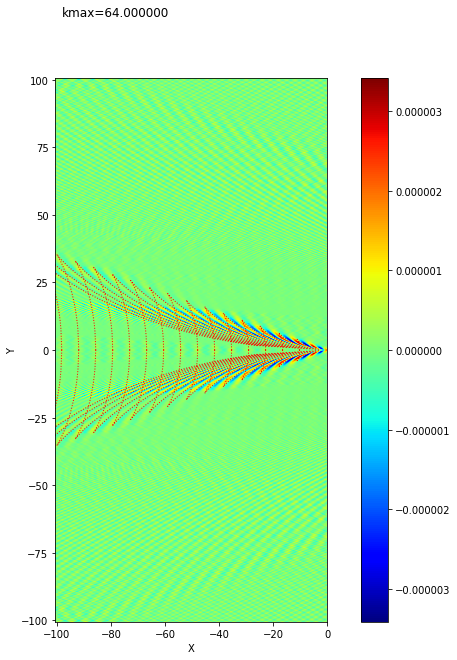

In [91]:
phase = 60.5/np.pi - 19.0

for ind in range(0, len(phis)):
    t = np.linspace(1, calc_T_value(kmaxs[ind]), 10000)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.gca()
    img = draw_wake_plot(ax, xvals[ind], phis[ind], kmaxs[ind], bounds[ind])
    format_single_plot(fig, img, title='kmax=%f' % kmaxs[ind])
    draw_parametric_wake(ax, phase, 16, t)
    filename = 'parametric_l=%f_kmax=%f_step=%f' % (lambd, kmaxs[ind], delts[ind])
    print(filename)
    #fig.savefig('/home/jcolen/Documents/kelvinmach/challenging_kelvin/pics/%s.png' % filename)
    plt.show()

Generation of high quality figure for the paper

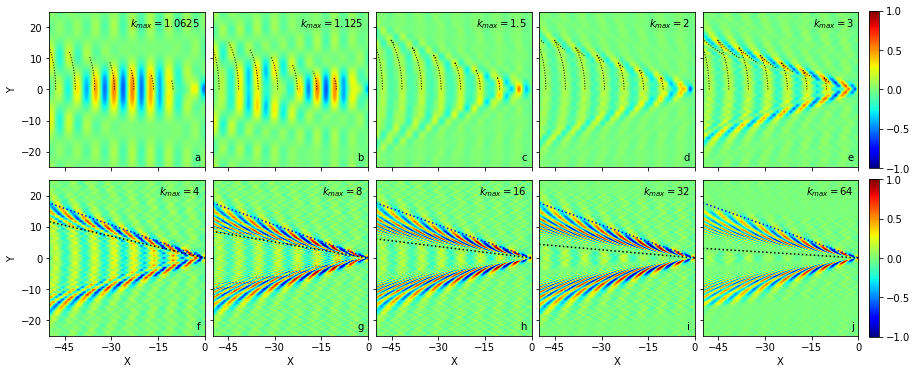

In [7]:
phase = 0.25

rows = np.array([[1.0625, 1.125, 1.5, 2, 3],
        [4, 8, 16, 32, 64]])
bounds = np.array([[100, 100, 100, 100, 10],
                   [6, 5, 3, 1.5, 1]])

xbounds = [-50, 0]
ybounds = [-25, 25]
npy, npx = rows.shape

fig, axes = plt.subplots(nrows=npy, ncols=npx, sharex='col', sharey='row', figsize=(14.5, 6))

label = 'a'
for j in range(npy):
    for i in range(npx):
        ax = axes[j][i]
        ind = kmaxs.index(rows[j, i])
        ax.set_adjustable('box-forced')
        ax.set_xlim(xbounds)
        ax.set_xticks(np.arange(xbounds[0], xbounds[-1]+1, 10))
        ax.set_ylim(ybounds)
        ax.set_yticks([-20, -10, 0, 10, 20])
        ax.set_xticks([-45, -30, -15, 0])
        ax.text(0.97, 0.97, r'$k_{max} = $%g' % kmaxs[ind], transform=ax.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        ax.text(0.97, 0.03, label, transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
        label = chr(ord(label) + 1)
        draw_wake_plot(ax, xvals[ind], phis[ind], kmaxs[ind], bound=bounds[j, i], scale=True)
        if j == 0:
            t = np.linspace(1, calc_T_value(kmaxs[ind]), 10000)
            draw_parametric_wake(ax, phase, 16, t, color='black')
        elif j == 1:
            draw_kelvin_angle(ax, xvals[ind])
            draw_inner_angle(ax, xvals[ind], calc_T_value(kmaxs[ind]), color='black')
            ax.set_xlabel('X')
        if i == 0:
            ax.set_ylabel('Y')        

fig.subplots_adjust(wspace=0.05, hspace=0.07)
#Add colorbars
for j in range(npy):
    bb = axes[j][i].get_position().bounds
    cbar_ax = fig.add_axes([bb[0]+bb[2] + 0.01, bb[1], 0.01, bb[3]])
    img = [obj for obj in axes[j][-1].get_children() if isinstance(obj, AxesImage)][0]
    plt.colorbar(img, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1.0])
    
plt.show()